In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from math import ceil, log2
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize
from pennylane.optimize import AdamOptimizer
from functools import partial
import time
import time
import warnings
warnings.filterwarnings("ignore")

In [39]:
SEED = 42
np.random.seed(SEED)

In [40]:
TICKER = "AAPL"        # change to any ticker (e.g., "SPY", "MSFT")
PERIOD = "5y"          # e.g., '5y', '2y'
INTERVAL = "1d"


In [41]:
def fetch_and_features(ticker=TICKER, period=PERIOD, interval=INTERVAL):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True)
    df = df.dropna()
    df['returns'] = df['Close'].pct_change().fillna(0)
    df['logret'] = np.log1p(df['returns'])
    df['ma_5'] = df['Close'].rolling(5).mean()
    df['ma_20'] = df['Close'].rolling(20).mean()
    df['vol_20'] = df['logret'].rolling(20).std()
    df['momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df = df.dropna()
    return df

In [42]:
df = fetch_and_features(TICKER, PERIOD, INTERVAL)
print("Data shape:", df.shape)
df.tail()

[*********************100%***********************]  1 of 1 completed

Data shape: (1237, 11)


Price,Close,High,Low,Open,Volume,returns,logret,ma_5,ma_20,vol_20,momentum_5
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2025-11-03,269.049988,270.850006,266.250000,270.420013,50194600,-0.004882,-0.004894,269.903998,259.127499,0.015418,0.000893
2025-11-04,270.040009,271.489990,267.619995,268.329987,49274800,0.003680,0.003673,270.112000,259.805499,0.015402,0.003866
2025-11-05,270.140015,271.700012,266.929993,268.609985,43683100,0.000370,0.000370,270.200000,260.409499,0.015386,0.001631
2025-11-06,269.769989,273.399994,267.890015,267.890015,51204000,-0.001370,-0.001371,269.873999,261.195999,0.014828,-0.006006
2025-11-07,268.470001,272.290009,266.769989,269.799988,48203600,-0.004819,-0.004831,269.494000,262.355999,0.012006,-0.007027


In [43]:
FEATURE_COLS = ['logret','ma_5','ma_20','vol_20','momentum_5']
X = df[FEATURE_COLS].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [44]:
angle_scaler = MinMaxScaler(feature_range=(0, np.pi))
X_angles = angle_scaler.fit_transform(Xs)

In [45]:
DESIRED_SUBSET = 250
available = X_angles.shape[0]
SUBSET_SIZE = DESIRED_SUBSET if available >= DESIRED_SUBSET else available
print(f"Using SUBSET_SIZE = {SUBSET_SIZE} (available rows: {available})")

Using SUBSET_SIZE = 250 (available rows: 1237)


In [46]:
X_sub = X_angles[-SUBSET_SIZE:].copy()
index_sub = df.index[-SUBSET_SIZE:]


In [47]:
forward_ret = df['returns'].shift(-1).loc[index_sub].fillna(0).values
y_target = np.where(forward_ret >= 0, 1.0, -1.0)

In [48]:
print("Subset shape:", X_sub.shape, "Target counts:", np.unique(y_target, return_counts=True))

Subset shape: (250, 5) Target counts: (array([-1.,  1.]), array([111, 139]))


In [49]:
n_features = X_sub.shape[1]
n_qubits = int(ceil(log2(n_features)))
dim = 2**n_qubits
print(f"Features: {n_features}, using {n_qubits} qubits (amplitude dim {dim})")

Features: 5, using 3 qubits (amplitude dim 8)


In [50]:
n_layers = 2 

In [51]:
dev = qml.device("default.qubit", wires=n_qubits)

In [52]:
# @qml.qnode(dev)
# def state_circuit(x_angles, theta_flat):
#     # x_angles: length n_features (<= dim); pad/truncate to dim then set RZ on each qubit
#     x = np.array(x_angles, dtype=float)
#     # pad x to dim if necessary (we already used scaling to angles)
#     if len(x) < dim:
#         x = np.concatenate([x, np.zeros(dim - len(x))])
#     # Map classical vector to qubit angles: apply RZ on each wire using first n_qubits elements
#     for i in range(n_qubits):
#         # qml.RZ(float(x[i]), wires=i)
#         qml.RY(float(x[i]), wires=i)
#            # static encoding
#     # variational layer(s)
#     # theta_flat is a 1D vector: length = n_layers * n_qubits * 2  (we use RX and RZ per qubit per layer)
#     thetas = np.array(theta_flat, dtype=float)
#     thetas = thetas.reshape((n_layers, n_qubits, 2))
#     for layer in range(n_layers):
#         for q in range(n_qubits):
#             qml.RX(thetas[layer,q,0], wires=q)
#             qml.RZ(thetas[layer,q,1], wires=q)
#         # entangling chain
#         for q in range(n_qubits - 1):
#             qml.CNOT(wires=[q, q+1])
#     return qml.state()

In [53]:
@qml.qnode(dev)
def state_circuit(x_angles, theta_flat):
    # angle embedding (first n_qubits values)
    qml.templates.AngleEmbedding(x_angles[:n_qubits], wires=range(n_qubits), rotation='Y')
    # then variational layers (same as before)
    thetas = np.array(theta_flat, dtype=float).reshape((n_layers, n_qubits, 2))
    for layer in range(n_layers):
        for q in range(n_qubits):
            qml.RX(thetas[layer,q,0], wires=q)
            qml.RZ(thetas[layer,q,1], wires=q)
        for q in range(n_qubits-1):
            qml.CNOT(wires=[q, q+1])
    return qml.state()


In [54]:
def states_for_theta(X_inputs, theta_flat, progress=False):
    """Return list/array of statevectors for each input and theta."""
    m = X_inputs.shape[0]
    states = []
    t0 = time.time()
    for i in range(m):
        sv = state_circuit(X_inputs[i], theta_flat)
        states.append(np.array(sv))
        if progress and (i+1) % 20 == 0:
            print(f"Computed state {i+1}/{m}")
    t1 = time.time()
    # print(f"States computed in {t1-t0:.2f}s")
    return np.vstack(states) 

In [55]:
def fidelity_kernel_from_states(states):
    """Given states (m x dim), return K with entries |<psi_i|psi_j>|^2."""
    # states may be complex; compute overlap matrix
    overlaps = np.dot(states, states.conj().T)   # shape (m,m)
    K = np.abs(overlaps)**2
    return K

In [56]:
theta0 = np.random.normal(0, 0.1, size=(n_layers * n_qubits * 2))
states = states_for_theta(X_sub, theta0, progress=True)
K0 = fidelity_kernel_from_states(states)
print("K0 shape:", K0.shape, "K0 sample:", K0[:3,:3])

Computed state 20/250
Computed state 40/250
Computed state 60/250
Computed state 80/250
Computed state 100/250
Computed state 120/250
Computed state 140/250
Computed state 160/250
Computed state 180/250
Computed state 200/250
Computed state 220/250
Computed state 240/250
K0 shape: (250, 250) K0 sample: [[1.         0.99485345 0.99981373]
 [0.99485345 1.         0.99369136]
 [0.99981373 0.99369136 1.        ]]


In [57]:
def kernel_target_alignment(K, y):
    """Normalized Frobenius inner product between kernel K and label kernel yy^T."""
    Y = np.outer(y, y)   # shape (m,m)
    num = np.sum(K * Y)
    den = np.linalg.norm(K, 'fro') * np.linalg.norm(Y, 'fro') + 1e-12
    return num / den

In [58]:
def objective_theta(theta_flat, X_inputs, y):
    """Objective to minimize: negative alignment (we want to maximize alignment)."""
    # compute states and kernel
    states = states_for_theta(X_inputs, theta_flat, progress=False)
    K = fidelity_kernel_from_states(states)
    align = kernel_target_alignment(K, y)
    loss = -align  # we minimize negative alignment
    return float(loss)

In [59]:
print("Initial loss:", objective_theta(theta0, X_sub, y_target))

Initial loss: -0.012642929498697416


In [60]:
learning_rate = 0.1
n_steps = 80               # start modest; increase after testing
theta = np.random.normal(0, 0.5, size=(n_layers * n_qubits * 2))

In [61]:
def loss_fn_for_opt(t):
    # returns scalar loss for optimizer (negative alignment)
    # IMPORTANT: keep function pure (no prints) for optimizer internals
    states = states_for_theta(X_sub, t, progress=False)
    K = fidelity_kernel_from_states(states)
    return -kernel_target_alignment(K, y_target)

In [62]:
try:
    print(f"Starting Adam optimization: steps={n_steps}, lr={learning_rate}")
    opt = AdamOptimizer(stepsize=learning_rate)
    start = time.time()
    for step in range(n_steps):
        theta, loss = opt.step_and_cost(loss_fn_for_opt, theta)
        if (step + 1) % 10 == 0 or step == 0:
            print(f"Step {step+1}/{n_steps}  loss={loss:.6f}")
    end = time.time()
    print(f"Adam finished in {end-start:.1f}s, final loss={loss:.6f}")
    theta_opt = theta.copy()
except Exception as e:
    # Fallback: COBYLA minimize (as in baseline)
    print("Adam optimization failed or not compatible in this environment. Error:", e)
    print("Falling back to COBYLA minimize (safe).")
    maxiter = 80
    theta_init = np.random.normal(0, 0.5, size=(n_layers * n_qubits * 2))
    start = time.time()
    res = minimize(fun=partial(objective_theta, X_inputs=X_sub, y=y_target),
                   x0=theta_init,
                   method='COBYLA',
                   options={'maxiter': maxiter, 'tol':1e-3, 'rhobeg':0.5})
    end = time.time()
    theta_opt = res.x
    print(f"COBYLA fallback finished in {end-start:.1f}s, success={res.success}, msg={res.message}")

Starting Adam optimization: steps=80, lr=0.1
Step 1/80  loss=-0.012643
Step 10/80  loss=-0.012643
Step 20/80  loss=-0.012643
Step 30/80  loss=-0.012643
Step 40/80  loss=-0.012643
Step 50/80  loss=-0.012643
Step 60/80  loss=-0.012643
Step 70/80  loss=-0.012643
Step 80/80  loss=-0.012643
Adam finished in 124.5s, final loss=-0.012643


In [63]:
# from functools import partial

# maxiter = 80           # adjust depending on how much compute time you want to commit
# theta_init = np.random.normal(0, 0.5, size=(n_layers * n_qubits * 2))

# print("Starting optimization (this will call the simulator many times)...")
# start = time.time()
# res = minimize(fun=partial(objective_theta, X_inputs=X_sub, y=y_target),
#                x0=theta_init,
#                method='COBYLA',
#                options={'maxiter': maxiter, 'tol':1e-3, 'rhobeg':0.5})
# end = time.time()
# theta_opt = res.x
# print("Optimization completed in %.1f s. Success: %s, msg: %s" % (end-start, res.success, res.message))
# print("Final loss:", res.fun)

Initial alignment: 0.012642929498697419
Trained alignment: 0.012642929498697417


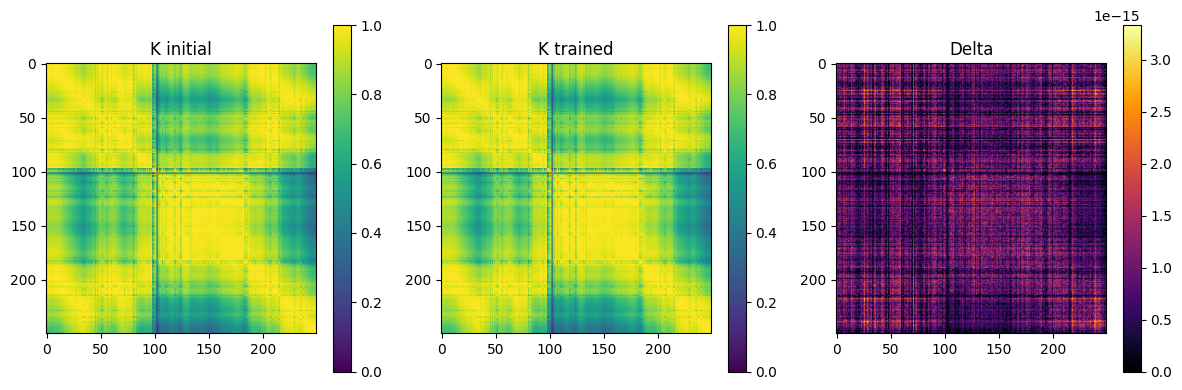

In [64]:
states_init = states_for_theta(X_sub, theta_init)
K_init = fidelity_kernel_from_states(states_init)
states_opt = states_for_theta(X_sub, theta_opt)
K_opt = fidelity_kernel_from_states(states_opt)

print("Initial alignment:", kernel_target_alignment(K_init, y_target))
print("Trained alignment:", kernel_target_alignment(K_opt, y_target))

# visualize small block of kernel matrices
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(K_init, cmap='viridis'); plt.title('K initial'); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(K_opt, cmap='viridis'); plt.title('K trained'); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(np.abs(K_opt - K_init), cmap='inferno'); plt.title('Delta'); plt.colorbar()
plt.tight_layout()
plt.show()

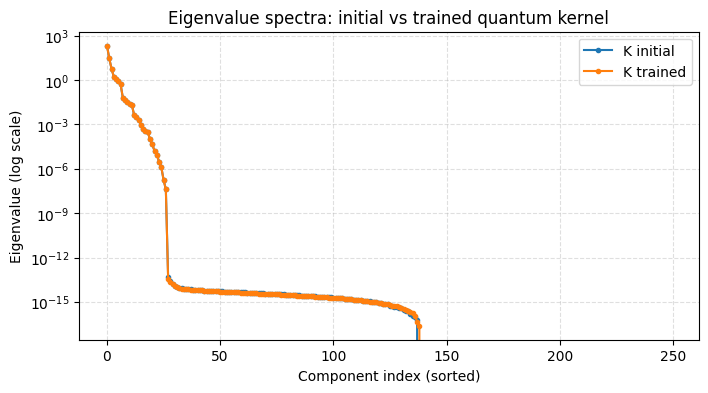

Top 5 eigenvalues (initial): [210.431016  29.17574    5.874353   1.727237   1.257803]
Top 5 eigenvalues (trained): [210.431016  29.17574    5.874353   1.727237   1.257803]


In [75]:
evals_init = np.sort(np.linalg.eigvalsh(K_init))[::-1]
evals_trained = np.sort(np.linalg.eigvalsh(K_opt))[::-1]

plt.figure(figsize=(8,4))
plt.plot(evals_init, label='K initial', marker='o', markersize=3)
plt.plot(evals_trained, label='K trained', marker='o', markersize=3)
plt.yscale('log')
plt.xlabel('Component index (sorted)')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Eigenvalue spectra: initial vs trained quantum kernel')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# Quick numeric summary for report
print("Top 5 eigenvalues (initial):", np.round(evals_init[:5], 6))
print("Top 5 eigenvalues (trained):", np.round(evals_trained[:5], 6))

In [76]:
# DIAGNOSTIC: check theta & kernel differences
import numpy as np

# ensure variables exist
assert 'theta0' in globals() or 'theta_init' in globals(), "theta0/theta_init not found"
assert 'theta_opt' in globals(), "theta_opt not found (run training cell first)"
assert 'K_init' in globals() and 'K_opt' in globals(), "K_init or K_opt missing"

t0 = globals().get('theta0', globals().get('theta_init'))
topt = theta_opt

theta_norm = np.linalg.norm(topt - t0)
theta_rel = theta_norm / (np.linalg.norm(t0) + 1e-16)
print(f"||theta_opt - theta_init|| = {theta_norm:.6e}, relative = {theta_rel:.6e}")

# Kernel differences
max_abs = np.max(np.abs(K_opt - K_init))
max_rel = np.max(np.abs((K_opt - K_init) / (K_init + 1e-16)))
mean_abs = np.mean(np.abs(K_opt - K_init))
print(f"Kernel max abs diff: {max_abs:.6e}, mean abs diff: {mean_abs:.6e}, max rel diff: {max_rel:.6e}")

# print a tiny sample
print("K_init[0:3,0:3]:\n", np.round(K_init[:3,:3],6))
print("K_opt[0:3,0:3]:\n", np.round(K_opt[:3,:3],6))


||theta_opt - theta_init|| = 1.908463e+00, relative = 6.415522e+00
Kernel max abs diff: 3.330669e-15, mean abs diff: 8.286110e-16, max rel diff: 3.347517e-15
K_init[0:3,0:3]:
 [[1.       0.994853 0.999814]
 [0.994853 1.       0.993691]
 [0.999814 0.993691 1.      ]]
K_opt[0:3,0:3]:
 [[1.       0.994853 0.999814]
 [0.994853 1.       0.993691]
 [0.999814 0.993691 1.      ]]


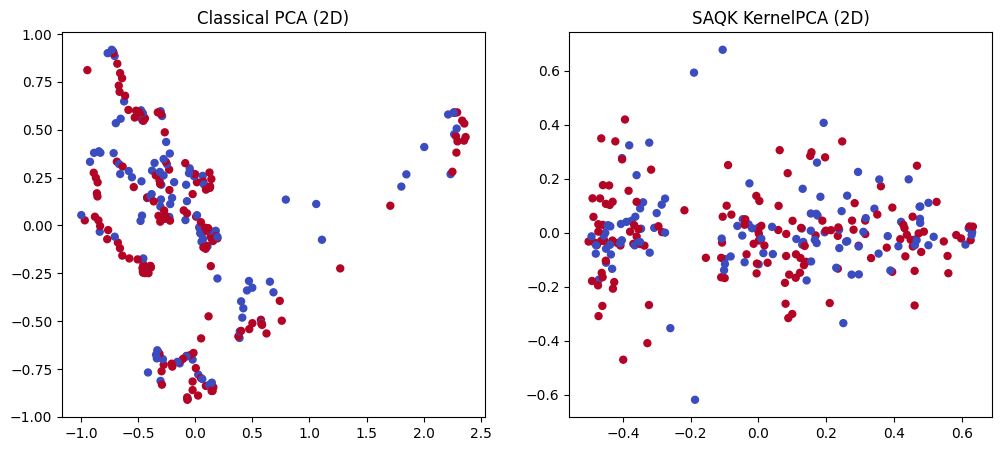

In [65]:
n_components = 3
kpca = KernelPCA(n_components=n_components, kernel='precomputed')
Zq = kpca.fit_transform(K_opt)   # shape (m, n_components)

# For comparison: classical PCA on same scaled features
pca = PCA(n_components=n_components)
Zc = pca.fit_transform(X_sub)

# plot first 2 components for both
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Zc[:,0], Zc[:,1], c=y_target, cmap='coolwarm', s=25)
plt.title('Classical PCA (2D)')
plt.subplot(1,2,2)
plt.scatter(Zq[:,0], Zq[:,1], c=y_target, cmap='coolwarm', s=25)
plt.title('SAQK KernelPCA (2D)')
plt.show()

In [66]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(Zq)
clusters = kmeans.labels_
sil = silhouette_score(Zq, clusters)
print("Silhouette score (SAQK embedding):", sil)

# compute forward returns (already extracted earlier in y_target calculation)
forward_returns_full = df['returns'].shift(-1).loc[index_sub].fillna(0)

cluster_perf = {}
for c in range(n_clusters):
    mask = clusters == c
    cluster_perf[c] = forward_returns_full.values[mask].mean()
print("Cluster forward mean returns:", cluster_perf)

best_cluster = max(cluster_perf, key=cluster_perf.get)
print("Selected cluster to long:", best_cluster)

signals = (clusters == best_cluster).astype(int)

Silhouette score (SAQK embedding): 0.4849678833090476
Cluster forward mean returns: {0: np.float64(0.0017312273637322215), 1: np.float64(-0.00042613894698781407), 2: np.float64(0.0008869910560481898)}
Selected cluster to long: 0


In [67]:
def backtest(signals, returns, cost_per_trade=0.0005):
    pos = pd.Series(signals, index=index_sub).shift(1).fillna(0)
    strat_rets = pos.values * returns.values
    trades = np.abs(np.diff(np.concatenate([[0], pos.values])))
    strat_rets = strat_rets - trades * cost_per_trade
    equity = np.cumprod(1 + strat_rets)
    return strat_rets, equity

In [68]:
rets_sub_series = df['returns'].loc[index_sub]
strat_rets, equity = backtest(signals, rets_sub_series)

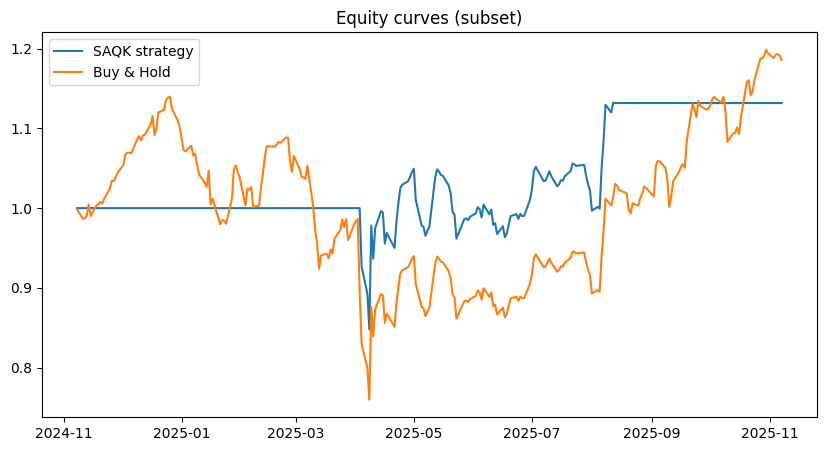

In [69]:
bh_equity = np.cumprod(1 + rets_sub_series.values)

plt.figure(figsize=(10,5))
plt.plot(index_sub, equity, label='SAQK strategy')
plt.plot(index_sub, bh_equity, label='Buy & Hold')
plt.legend(); plt.title('Equity curves (subset)')
plt.show()

In [70]:
def sharpe(returns, freq=252):
    return np.mean(returns) / (np.std(returns) + 1e-9) * np.sqrt(freq)

In [71]:
print("SAQK strategy total return:", equity[-1]-1, "Sharpe:", sharpe(strat_rets))
print("Buy & Hold total return:", bh_equity[-1]-1, "Sharpe:", sharpe(rets_sub_series.values))

SAQK strategy total return: 0.13181224401904346 Sharpe: 0.6252838562082563
Buy & Hold total return: 0.18568430308426787 Sharpe: 0.6888170548463669


In [72]:
out = pd.DataFrame(index=index_sub)
out['cluster'] = clusters
out['signal'] = signals
out['next_return'] = df['returns'].shift(-1).loc[index_sub].fillna(0)
out['strategy_ret'] = np.concatenate([[0], np.diff(equity) / equity[:-1]])  # approximate daily strat ret
out.to_csv('saqk_stock_results.csv')
print("Saved results to saqk_stock_results.csv")

print("Final summary:")
print(" - Subset size:", len(index_sub))
print(" - Trained alignment:", kernel_target_alignment(K_opt, y_target))
print(" - Silhouette:", sil)
print(" - Strategy total return:", equity[-1]-1)
print(" - Strategy Sharpe:", sharpe(strat_rets))

Saved results to saqk_stock_results.csv
Final summary:
 - Subset size: 250
 - Trained alignment: 0.012642929498697417
 - Silhouette: 0.4849678833090476
 - Strategy total return: 0.13181224401904346
 - Strategy Sharpe: 0.6252838562082563
